## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [80]:
import os
import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [81]:
train, test = keras.datasets.cifar10.load_data()

In [89]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [90]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [91]:
from keras.layers import BatchNormalization, Dropout, ReLU

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = BatchNormalization()(x)
            
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(0.3)(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [92]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [93]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import f1_score
from keras.metrics import TrueNegatives, TruePositives

class f1sc(Callback):
    
    def __init__(self,val_x, val_y, batch_size = 20):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size

    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        self.params['metrics']= []
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
       
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):

      logs = logs or {}
      y_true = self.val_y.argmax(axis = 1)
      y_pred = self.model.predict(self.val_x)
      y_pred = (y_pred[:, 1] >= thres) * 1

      logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")

      tn = TrueNegatives()
      tn.update_state(y_true,y_pred)
      logs["val_tn"] = tn.result().numpy()

      tp = TruePositives()
      tp.update_state(y_true,y_pred)
      logs["val_tp"] = tp.result().numpy()

        
log_f1sc = f1sc(x_test, y_test, BATCH_SIZE)

In [94]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_f1sc]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# 在訓練後，將紀錄調出
valid_f1sc = model.history.history['val_f1sc']
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_48 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               328

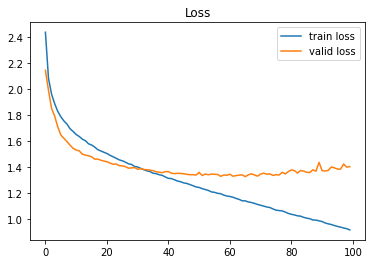

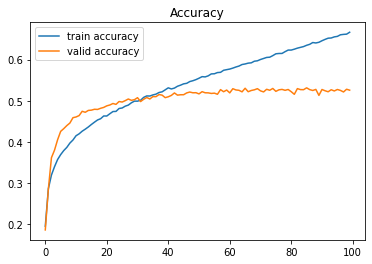

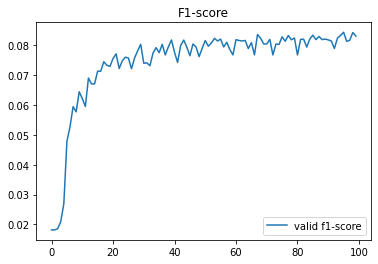

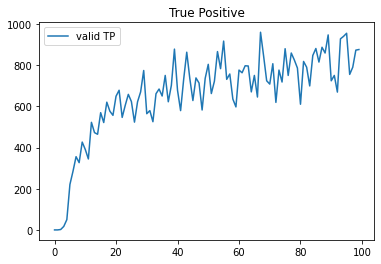

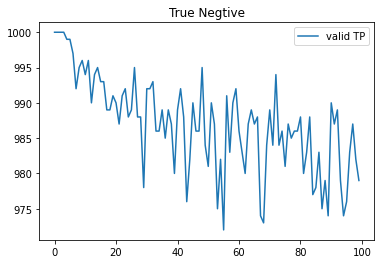

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_tp, label="valid TP")
plt.legend()
plt.title("True Positive" )
plt.show()


plt.plot(range(len(valid_f1sc)), valid_tn, label="valid TP")
plt.legend()
plt.title("True Negtive")
plt.show()